In [1]:
def f(x):
    return x**4 + 12 * x + 1 / x

In [2]:
def print_dir(x):
    attrs = []
    for attr in dir(x):
        if not attr.startswith("__"):
            attrs.append(attr)
    for a, b in zip(*(iter(attrs),) * 2):
        print(f"{a:40}{b}")

In [3]:
list()

[]

# Manual differentiation

In [4]:
def df(x):
    return 4 * x**3 + 12 - 1 / x**2

In [5]:
x = 11.0
print(f(x), df(x))

14773.09090909091 5335.99173553719


# Symbolic differentiation

In [6]:
import sympy

x_sym = sympy.symbols("x")

f_sym = f(x_sym)
f_sym

x**4 + 12*x + 1/x

In [7]:
df_sym = sympy.diff(f_sym)
df_sym

4*x**3 + 12 - 1/x**2

In [8]:
sympy.lambdify(x_sym, f_sym)(x), sympy.lambdify(x_sym, df_sym)(x)

(14773.09090909091, 5335.99173553719)

# Numerical differentiation

In [9]:
dx = 1e-8

df_numeric = (f(x + dx) - f(x)) / dx
df_numeric

5335.992136679124

# Auto differentiation

In [10]:
import jax

df = jax.grad(f)
df(x)

Array(5335.9917, dtype=float32, weak_type=True)

In [11]:
import jax

In [12]:
df = jax.grad(f)

In [13]:
df(x)

Array(5335.9917, dtype=float32, weak_type=True)

In [14]:
def loop(x):
    for i in range(4):
        x = x * x
    return x

In [15]:
loop(2)

65536

In [16]:
loop_grad = jax.grad(loop)
loop_grad(2.0)

Array(524288., dtype=float32, weak_type=True)

In [17]:
loop_sym = x_sym**16
loop_sym

x**16

In [18]:
loop_sym_grad = sympy.diff(loop_sym)
loop_sym_grad

16*x**15

In [19]:
sympy.lambdify(x_sym, loop_sym)(2), sympy.lambdify(x_sym, loop_sym_grad)(2)

(65536, 524288)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 10 * np.pi, num=1000)
e = np.random.normal(scale=10.0, size=x.size)
y = 65.0 + 1.8 * x + 40 * np.cos(x) + e

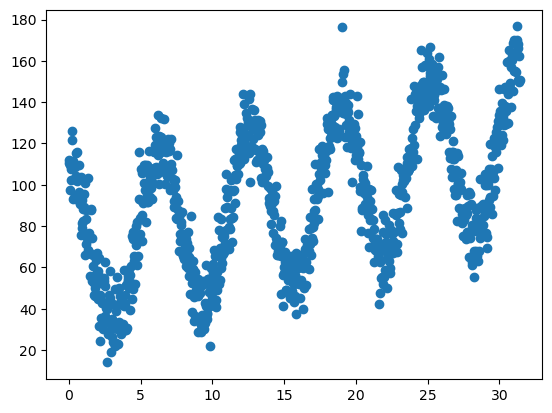

In [21]:
plt.scatter(x, y)

# Auto grad in pytorch

In [22]:
import torch

In [23]:
xt = torch.tensor(x)
yt = torch.tensor(y)
lr = 1e-2

w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)


def model(x):
    return w * x + b


def loss_fn(pred, y):
    return ((pred - y) ** 2).mean()


pred = model(xt)
loss = loss_fn(pred, yt)

loss.backward()

with torch.no_grad():
    w -= w.grad * lr
    b -= b.grad * lr
    w.grad.zero_()
    b.grad.zero_()

w, b

(tensor(26.5262, requires_grad=True), tensor(2.5391, requires_grad=True))

## Auto grad in JAX

In [24]:
from jax import grad, make_jaxpr
from jax import numpy as jnp


xt = jnp.array(x)
yt = jnp.array(y)
lr = 1e-2

model_params = jnp.array([1.0, 1.0])


def model(theta, x):
    w, b = theta
    return w * x + b


def loss_fn(model_params, x, y):
    pred = model(model_params, x)
    return jnp.mean((pred - y) ** 2)


grad_fn = grad(loss_fn)
grads = grad_fn(model_params, xt, yt)
model_params -= lr * grads

model_params

Array([26.526203,  2.53905 ], dtype=float32)

In [25]:
grads

Array([-2552.6204,  -153.905 ], dtype=float32)

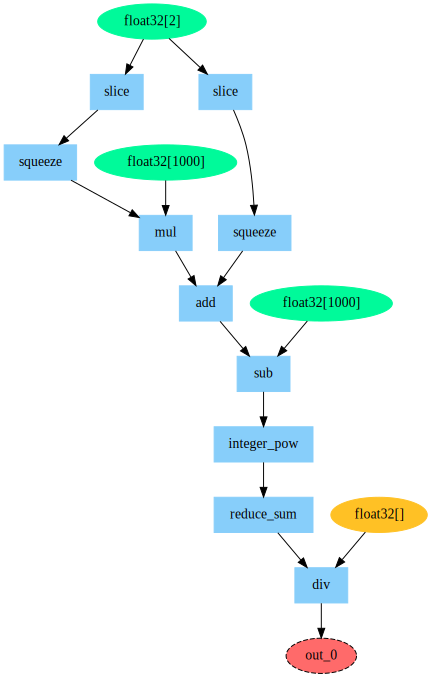

In [26]:
import util

util.jaxpr_graph(loss_fn, model_params, xt, yt)

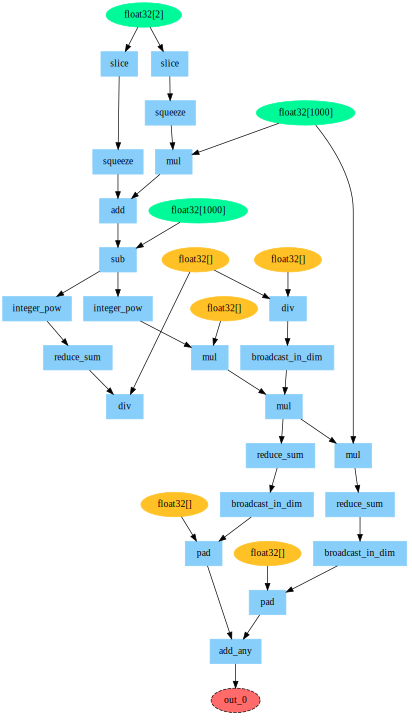

In [27]:
util.jaxpr_graph(grad_fn, model_params, xt, yt)

In [28]:
test = make_jaxpr(grad_fn)(model_params, xt, yt)
test

{ lambda ; a:f32[2] b:f32[1000] c:f32[1000]. let
    d:f32[1] = slice[limit_indices=(1,) start_indices=(0,) strides=(1,)] a
    e:f32[] = squeeze[dimensions=(0,)] d
    f:f32[1] = slice[limit_indices=(2,) start_indices=(1,) strides=(1,)] a
    g:f32[] = squeeze[dimensions=(0,)] f
    h:f32[1000] = mul e b
    i:f32[1000] = add h g
    j:f32[1000] = sub i c
    k:f32[1000] = integer_pow[y=2] j
    l:f32[1000] = integer_pow[y=1] j
    m:f32[1000] = mul 2.0 l
    n:f32[] = reduce_sum[axes=(0,)] k
    _:f32[] = div n 1000.0
    o:f32[] = div 1.0 1000.0
    p:f32[1000] = broadcast_in_dim[broadcast_dimensions=() shape=(1000,)] o
    q:f32[1000] = mul p m
    r:f32[] = reduce_sum[axes=(0,)] q
    s:f32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] r
    t:f32[2] = pad[padding_config=((1, 0, 0),)] s 0.0
    u:f32[1000] = mul q b
    v:f32[] = reduce_sum[axes=(0,)] u
    w:f32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] v
    x:f32[2] = pad[padding_config=((0, 1, 0),)]

In [29]:
print_dir(test.jaxpr.eqns[0])

_asdict                                 _field_defaults
_fields                                 _make
_replace                                count
effects                                 index
invars                                  outvars
params                                  primitive
replace                                 source_info


In [30]:
test.jaxpr.eqns[0]

a:f32[1] = slice[limit_indices=(1,) start_indices=(0,) strides=(1,)] b

In [31]:
test.jaxpr.eqns[0]._asdict()

{'invars': [a],
 'outvars': [d],
 'primitive': slice,
 'params': {'start_indices': (0,), 'limit_indices': (1,), 'strides': (1,)},
 'effects': frozenset(),
 'source_info': SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7fb0946ef470>, name_stack=NameStack(stack=(Transform(name='jvp'),)))}

In [32]:
(
    jnp.sum(((2 * (model(jnp.array([1.0, 1.0]), xt) - yt)) * 1 / 1000) * xt),
    jnp.sum(((2 * (model(jnp.array([1.0, 1.0]), xt) - yt)) * 1 / 1000)),
)

(Array(-2552.6204, dtype=float32), Array(-153.905, dtype=float32))

In [33]:
grads

Array([-2552.6204,  -153.905 ], dtype=float32)

## argnums in grad

determines which positional argument to differentiate with respect to.

In [34]:
def f(x, y):
    return x**2 + 2 * y

In [39]:
df_dx = grad(f, argnums=0)  # df/dx = 2x since x is first parameter
df_dx(2.0, 10.0)

Array(4., dtype=float32, weak_type=True)

In [40]:
df_dy = grad(f, argnums=1)  # df/dy = 2
df_dy(4.0, 10.0)

Array(2., dtype=float32, weak_type=True)

In [41]:
# ? diff with both x and y
df_dx_dy = grad(f, argnums=(0, 1))
df_dx_dy(5.0, 11.0)

(Array(10., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True))

### diff using dict

In [45]:
xt = jnp.array(x)
yt = jnp.array(y)
lr = 1e-2

model_params = {"w": jnp.array(1.0), "b": jnp.array(1.0)}


def model(theta, x):
    w, b = theta["w"], theta["b"]
    return w * x + b


def loss_fn(model_params, x, y):
    pred = model(model_params, x)
    return jnp.mean((pred - y) ** 2)


grad_fn = grad(loss_fn)
grads = grad_fn(model_params, xt, yt)
grads

{'b': Array(-153.905, dtype=float32, weak_type=True),
 'w': Array(-2552.6204, dtype=float32, weak_type=True)}

### has_aux

1. fn should return a scalar (which includes arrays with shape () but not arrays with shape (1,) etc.
2. indicates whether fun returns a pair where the first element is considered the output of the mathematical function to be differentiated and the second element is auxiliary data.

In [46]:
def f(x, y):
    res = x**2 + 2 * y
    return res, res

In [50]:
df_dx_dy = grad(f, argnums=(0, 1))
try:
    df_dx_dy(5.0, 11.0)
except TypeError as e:
    print(e)

Gradient only defined for scalar-output functions. Output was (Array(47., dtype=float32, weak_type=True), Array(47., dtype=float32, weak_type=True)).


In [51]:
df_dx_dy = grad(f, argnums=(0, 1), has_aux=True)
df_dx_dy(5.0, 11.0)

((Array(10., dtype=float32, weak_type=True),
  Array(2., dtype=float32, weak_type=True)),
 Array(47., dtype=float32, weak_type=True))

### return the loss and grad as same time

In [52]:
def f(x, y):
    return x**2 + 2 * y

df_dx_dy = jax.value_and_grad(f, argnums=(0, 1))
df_dx_dy(5.0, 11.0)

(Array(47., dtype=float32, weak_type=True),
 (Array(10., dtype=float32, weak_type=True),
  Array(2., dtype=float32, weak_type=True)))